In [1]:
!pip install git+https://github.com/datamllab/rlcard

  Cloning https://github.com/datamllab/rlcard to /tmp/pip-req-build-i9chvjnq
  Running command git clone -q https://github.com/datamllab/rlcard /tmp/pip-req-build-i9chvjnq
  Created wheel for rlcard: filename=rlcard-0.2.6-cp36-none-any.whl size=6785365 sha256=f416fa8eba182e92bb362697c44182d5de5430e45b91d33669aa4ed0bd5485cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-b4nq4qcl/wheels/b3/e1/32/6535ad7ff9142e4c031af97e237e4df3e4ab14e86194738ac4
Successfully built rlcard


In [2]:
%tensorflow_version 1.x # for using tensorflow.contrib
import tensorflow as tf

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # for using tensorflow.contrib`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
from collections import namedtuple
import random
import numpy as np

Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayMemory(object):
    ''' 
    Replay memory for saving transitions
    '''
    def __init__(self, capacity, batch_size):
        ''' 
        Initialize ReplayMemory

        :param int capacity: the size of the memory buffer
        :param int batch_size: the size of the batches
        '''
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        '''
        Save a transition into memory
        '''
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        '''
        Choose random sample from the memory with size of the batch size
        '''
        samples = random.sample(self.memory, batch_size)
        return map(np.array, zip(*samples))



In [4]:
import numpy as np
import torch
import torch.nn as nn

class DQN_network(object):
    '''
    Deep Q-Network
    '''

    def __init__(self, state_no=36, act_no=4, hidden_layers=[64, 32], learning_rate=0.001, device=None):
        ''' 
        Initilalize the DQN_network object.

        :param act_no (int): Number of actions (4 in Leduc Hold'em)
        :param state_no (list): Size of the state space (36 in Leduc Hold'em)
        :param hidden_layers (list): Dimension of the hidden layers
        :param device (torch.device): Usage CPU or GPU
        '''
        self.state_no = state_no
        self.act_no = act_no
        self.hidden_layers = hidden_layers
        self.learning_rate=learning_rate
        self.device = device

        # DQN network based on the layers
        layers = self.state_no + self.hidden_layers
        DQN_network = [nn.Flatten()]
        DQN_network.append(nn.BatchNorm1d(layers[0]))
        for i in range(len(layers)-1):
            DQN_network.append(nn.Linear(layers[i], layers[i+1], bias=True))
            DQN_network.append(nn.Tanh())
        DQN_network.append(nn.Linear(layers[-1], self.act_no, bias=True))
        DQN_network = nn.Sequential(*DQN_network)

        DQN_network = DQN_network.to(self.device)
        self.DQN_network = DQN_network
        self.DQN_network.eval()

        # Initialize weights in the network
        for p in self.DQN_network.parameters():
            if len(p.data.shape) > 1:
                nn.init.xavier_uniform_(p.data)

        # Define loss function
        self.loss_function = nn.MSELoss(reduction='mean')

        # Define optimizer
        #self.optimizer =  torch.optim.Adam(self.DQN_network.parameters(), lr=self.learning_rate)
        self.optimizer = torch.optim.RMSprop(self.DQN_network.parameters())


    def get_qvalue(self, next_state_batch):
        ''' 
        Get Q-values for the batch of the next states.
        It does not use gradient calculation.

        :param np.ndarray next_state_batch: Batch of the next states
        :return np.ndarray Q_values: The estimated Q-values
        '''
        # Disable gradient calculation
        with torch.no_grad():
            # Create torch tensor
            next_state_batch = torch.from_numpy(next_state_batch).float().to(self.device)
            # Get Q values
            Q_values = self.DQN_network(next_state_batch).cpu().numpy()
        return Q_values

    def update(self, state_batch, action_batch, target_batch):
        ''' 
        Update the policy network

        :param np.ndarray state_batch: Batch of states from replay memory
        :param np.ndarray action_batch: Batch of actions from replay memory
        :param np.ndarray target_batch: Batch of Q-values from the target policy, it used during the optimization step
        :return float batch_loss: The calculated loss on the batch       
        '''
        # Set the gradients to zero
        self.optimizer.zero_grad()

        # Set the network in training mode
        self.DQN_network.train()

        # Create torch tensors
        state_batch = torch.from_numpy(state_batch).float().to(self.device)
        action_batch = torch.from_numpy(action_batch).long().to(self.device)
        target_batch = torch.from_numpy(target_batch).float().to(self.device)

        # Gather Q-values from network and replay memory actions
        Q_values = torch.gather(self.DQN_network(state_batch), dim=-1, index=action_batch.unsqueeze(-1)).squeeze(-1)

        # Optimization step
        batch_loss = self.loss_function(Q_values, target_batch)
        batch_loss.backward()
        self.optimizer.step()
        batch_loss = batch_loss.item()
        self.DQN_network.eval()
        return batch_loss


In [5]:
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy
import random

class DQN_agent(object):
    '''
    DQN agent
    '''
    def __init__(self,
                state_no,
                act_no,
                replay_memory_capacity=20000,
                replay_memory_min_sample=1000,
                batch_size=32,
                training_period=1,
                discount_factor=0.99,
                hidden_layers=[64, 32],
                learning_rate=0.0001,
                epsilon_decay_steps=20000,
                update_target_dqn_period=1000, 
                device=None):

        '''
        Initialize the DQN agent

        :param int state_no: Number of states
        :param int act_no: Number of actions
        :param int replay_memory_capacity: Replay memory size
        :param int replay_memory_min_sample: Minimum number of samples in the replay memory during sampling
        :param int batch_size: Size of batches to sample from the replay memory
        :param int training_period: Train the network in every N steps
        :param float discount_factor: Discount factor (gamma) during training the agent
        :param list[int] hidden_layers: Dimensions of the hidden layers in the DQN network
        :param float learning_rate: The learning rate in the DQN network
        :param int epsilon_decay_steps: Number of steps to decay epsilon
        :param int update_target_dqn_period: Update target network in every N steps
        :param torch.device device: Usage CPU or GPU
        '''
        
        self.replay_memory_min_sample = replay_memory_min_sample
        self.update_target_dqn_period = update_target_dqn_period
        self.discount_factor = discount_factor
        self.epsilon_decay_steps = epsilon_decay_steps
        self.batch_size = batch_size
        self.act_no = act_no
        self.training_period = training_period

        # Torch device on which a torch.Tensor will be allocated
        if device is None:
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        # Create the replay memory
        self.memory = ReplayMemory(replay_memory_capacity, batch_size)

        # Initialize current timestep and current training timestep
        self.current_timestep, self.current_training_timestep = 0, 0

        # Create array for the epsilon values during the epsilon decay 
        self.epsilons = np.linspace(1.0, 0.1, epsilon_decay_steps)

        # Create the policy and the target network
        self.policy_dqn = DQN_network(act_no=act_no, learning_rate=learning_rate, state_no=state_no, hidden_layers=hidden_layers, device=self.device)
        self.target_dqn = DQN_network(act_no=act_no, learning_rate=learning_rate, state_no=state_no, hidden_layers=hidden_layers, device=self.device)

        # Set use_raw value for the RLCard environment
        self.use_raw = False

    def store_and_train(self, transition):
        ''' 
        Save transition into memory and train the agent based on the training period.

        :param tuple transition: The transition tuple 'state', 'action', 'reward', 'next_state', 'done'
        
        '''
        (state, action, reward, next_state, done) = tuple(transition)

 ######       ##### replay memory pop 

        # Store transition in replay memory
        self.memory.push(state['obs'], action, reward, next_state['obs'], done)
        # Increment the number of timesteps
        self.current_timestep += 1
        # Train the agent if the replay memory has data already and agent reached the next training period
        time_between = self.current_timestep - self.replay_memory_min_sample
        if time_between>=0 and time_between%self.training_period == 0:
            self.train()

    def discard_invalid_actions(self, action_probs, valid_actions):
        ''' 
        Remove invalid actions and normalize the probabilities.

        :param numpy.array[float] action_probs: Probabilities of all action
        :param list[int] valid_actions: Valid actions in the current state
        :return numpy.array[float] norm_valid_action_probs: Probabilities of valid actions
        '''
        # Initialize new array
        norm_valid_action_probs = np.zeros(action_probs.shape[0])
        # Add probability values of valid actions to the array
        norm_valid_action_probs[valid_actions] = action_probs[valid_actions]
        # Normalize probabilities
        norm_valid_action_probs[valid_actions] = 1 / len(valid_actions)
        return norm_valid_action_probs

    def predict(self, state):
        ''' 
        Predict the action probabilities.

        :param numpy.array[float] state: Current state
        :return numpy.array[float] q_values: Array of Q values  
        '''
        epsilon = self.epsilons[min(self.current_timestep, self.epsilon_decay_steps-1)]
        actions = np.ones(self.act_no, dtype=float) * epsilon / self.act_no
        q_values = self.policy_dqn.get_qvalue(np.expand_dims(state, 0))[0]
        best_action = np.argmax(q_values)
        actions[best_action] += (1.0 - epsilon)
        return actions

    def step(self, state):
        ''' 
        Define step function for the RLCard environment.
        Get the action for the current state for training purpose.
        If neccessary, remove invalid action pobabilities.

        :param numpy.array state: The current state
        :return int action: The chosen action in the current state
        '''
        actions = self.predict(state['obs'])
        norm_valid_action_probs = self.discard_invalid_actions(actions, state['legal_actions'])
        action = np.random.choice(np.arange(len(actions)), p=norm_valid_action_probs)
        return action


    def eval_step(self, state):
        ''' 
        Define eval_step function for the RLCard environment.
        Get the action for the evaluation purpose instead of training purpose.

        :param numpy.array state: The current state
        :return int action: The chosen action in the current state
        '''
        q_values = self.policy_dqn.get_qvalue(np.expand_dims(state['obs'], 0))[0]
        norm_valid_action_probs = self.discard_invalid_actions(np.exp(q_values), state['legal_actions'])
        best_action = np.argmax(norm_valid_action_probs)
        return best_action, norm_valid_action_probs

    
    def train(self):
        ''' 
        Train the agent.

        return float loss: The loss of the current batch
        '''
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)

        # Get best next action using the policy network
        q_values_next = self.policy_dqn.get_qvalue(next_state_batch)
        best_actions = np.argmax(q_values_next, axis=1)

        # Calculate Q values from the target policy
        q_values_next_target = self.target_dqn.get_qvalue(next_state_batch)
        target_batch = reward_batch + np.invert(done_batch).astype(np.float32) * self.discount_factor * q_values_next_target[np.arange(self.batch_size), best_actions]

        # Update policy network
        state_batch = np.array(state_batch)
        loss = self.policy_dqn.update(state_batch, action_batch, target_batch)

        # Update target network based on the target update period
        if self.current_training_timestep % self.update_target_dqn_period == 0:
            self.target_dqn = deepcopy(self.policy_dqn)

        self.current_training_timestep += 1


    def get_state_dict(self):
        ''' 
        Get the state dictionaries.

        :return dict model_dict: Dictionaries containing the whole state of the policy and target modules
        '''
        model_dict = {'policy_network': self.policy_dqn.DQN_network.state_dict(), 'target_network': self.target_dqn.DQN_network.state_dict()}
        return model_dict

    def load_networks(self, checkpoint):
        ''' 
        Load network models.

        :param dict checkpoint: Checkpoint of the policy and target networks
        '''
        self.policy_dqn.DQN_network.load_state_dict(checkpoint['policy_network'])
        self.target_dqn.DQN_network.load_state_dict(checkpoint['target_network'])




----------------------------------------
  timestep     |  1
  reward       |  1.78
----------------------------------------

----------------------------------------
  timestep     |  36
  reward       |  1.52
----------------------------------------

----------------------------------------
  timestep     |  59
  reward       |  1.02
----------------------------------------

----------------------------------------
  timestep     |  83
  reward       |  2.025
----------------------------------------

----------------------------------------
  timestep     |  116
  reward       |  1.175
----------------------------------------

----------------------------------------
  timestep     |  144
  reward       |  1.795
----------------------------------------

----------------------------------------
  timestep     |  168
  reward       |  1.275
----------------------------------------

----------------------------------------
  timestep     |  186
  reward       |  2.04
------------------

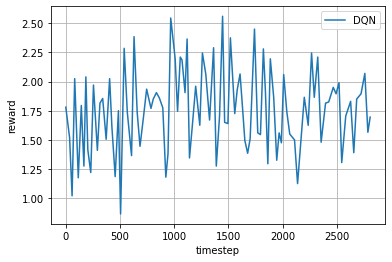

In [6]:
import rlcard
from rlcard import models
from rlcard.agents import RandomAgent
from rlcard.utils import seeding, tournament
from rlcard.utils import Logger
import torch
import os

# Create environments
env = rlcard.make('limit-holdem', config={'seed': 0})
eval_env = rlcard.make('limit-holdem', config={'seed': 0})

# Set a global seed
seeding.create_seed(0)

# The paths for saving the logs and learning curves
log_dir = './experiments/limit_holdem_dqn_result/'

# Create DQN agent
agent = DQN_agent(state_no=env.state_shape,
                 act_no=env.action_num, 
                 replay_memory_min_sample=1000,
                 training_period=10,
                 hidden_layers=[128, 128],
                 device=torch.device('cpu'))

# Create a random agent
random_agent = RandomAgent(action_num=eval_env.action_num)

# Create a pre-trained NFSP agent
#pretrained_agent = models.load('leduc-holdem-nfsp').agents[0]

# Add the agent to the environments
env.set_agents([agent, random_agent])
eval_env.set_agents([agent, random_agent])
# eval_env.set_agents([agent, pretrained_agent])

# Initialize logger
logger = Logger(log_dir)

# Number of episodes, number of games during evaluation and evaluation in every N steps
episode_no, evaluate_games, evaluate_period = 1000, 100, 10

for episode in range(episode_no):
    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.store_and_train(ts)

    # Evaluate the performance
    if episode % evaluate_period == 0:
        logger.log_performance(env.timestep, tournament(eval_env, evaluate_games)[0])

# Close files in the logger
logger.close_files()

# Plot the learning curve
logger.plot('DQN')

# Save model
save_dir = 'models/dqn'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model.pth'))